# Conversion rate challenge

# Import libraries

In [186]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

from xgboost import XGBClassifier
from IPython.display import display

# Read file with labels

In [187]:
data = pd.read_csv('src/conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


# Explore dataset

## Understanding the data

In [188]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


## Basic Descriptive Statistics

In [189]:
display(data.describe(include='all'))
print(data.shape)

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


(284580, 6)


### Count categorical values

In [190]:
country_count = data['country'].value_counts().reset_index()
print(country_count)

source_count = data['source'].value_counts().reset_index()
print(source_count)

new_user_count = data['new_user'].value_counts().reset_index()
print(new_user_count)

   country   count
0       US  160124
1    China   69122
2       UK   43641
3  Germany   11693
   source   count
0     Seo  139477
1     Ads   80027
2  Direct   65076
   new_user   count
0         1  195066
1         0   89514


## Looking for missing values

In [191]:
print(data.isnull().sum()/len(data)*100)

country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64


In [192]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

## Distribution of Numerical Variables

In [193]:
# Univariate analysis
# Distribution of each numeric variable
num_features = ["age", "total_pages_visited"]
for f in num_features:
    fig = px.histogram(
        data_sample,
        f,
        color="converted",
        facet_row="converted",
        histnorm="probability",
        height=600,
        width=700
    )
    fig.show()


In [194]:
num_features = ["age", "total_pages_visited"]

fig = make_subplots(rows=1, cols=len(num_features))

for index, feature in enumerate(num_features,start=1):
    fig.add_trace(go.Box(y=data_sample[feature], name=feature), row=1, col=index)
    
fig.update_layout(height=800, width=600)
fig.show()

## Correlation Analysis

In [195]:
df_corr = data_sample[['age','total_pages_visited']]
corr_matrix = df_corr.corr().round(2)

fig = px.imshow(corr_matrix, text_auto=True)
fig.show()

## Categorical Variable Analysis

#### Bar plots

In [196]:
categorical_features=['country','source','new_user']

for feature in categorical_features:
    fig = px.bar(data_sample[feature].value_counts(), labels={'value':'count'},
                width=800,
                height=450)
    fig.show()

#### Conversion Rate

In [197]:

# Function that compute the conversion rate for a given country
def conversion_rate(df, country):
    df_filtered = df.filter(items=['country','converted'])
    df_converted = df_filtered[(df_filtered['country'] == country) & (df_filtered['converted'] == 1)]
    conversion_rate = len(df_converted) / len(df_filtered) * 100
    return conversion_rate

countries = data_sample['country'].unique()
conversion_rate = [conversion_rate(data_sample,country) for country in countries]

display_df = pd.DataFrame({'country':countries,'conversion_rate':conversion_rate})

fig = px.bar(display_df, x='country', y='conversion_rate',
             height=500,
             width=800,
             labels={'conversion_rate':'conversion rate (percent)'})
fig.show()


In [198]:
for feature in categorical_features:
    fig = px.bar(data_sample[feature].value_counts(), labels={'value':'count'},
                width=800,
                height=450)
    fig.show()

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [199]:
features_list = ['total_pages_visited']
target_variable = 'converted'

In [200]:
X = data_sample.loc[:, features_list]
Y = data_sample.loc[:, target_variable]

In [201]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [202]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.25193661]
 [-0.25193661]
 [-0.25193661]
 [ 0.35678973]
 [ 0.05242656]]


In [203]:
# Train model
print("Train model...")
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [204]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [205]:
# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.25193661]
 [-1.16502612]
 [ 0.66115289]
 [-0.25193661]
 [-0.25193661]]


In [206]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [207]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.6876513317191283
f1-score on test set :  0.6956521739130435


In [301]:
def conf_matrix(model):
    _, ax = plt.subplots()  # Get subplot from matplotlib
    ax.set(
        title="Confusion Matrix on Train set"
    )  # Set a title that we will add into ConfusionMatrixDisplay
    ConfusionMatrixDisplay.from_estimator(
        model, X_train, Y_train, ax=ax
    )  # ConfusionMatrixDisplay from sklearn
    plt.show()

    _, ax = plt.subplots()  # Get subplot from matplotlib
    ax.set(
        title="Confusion Matrix on Test set"
    )  # Set a title that we will add into ConfusionMatrixDisplay
    ConfusionMatrixDisplay.from_estimator(
        model, X_test, Y_test, ax=ax
    )  # ConfusionMatrixDisplay from sklearn
    plt.show()

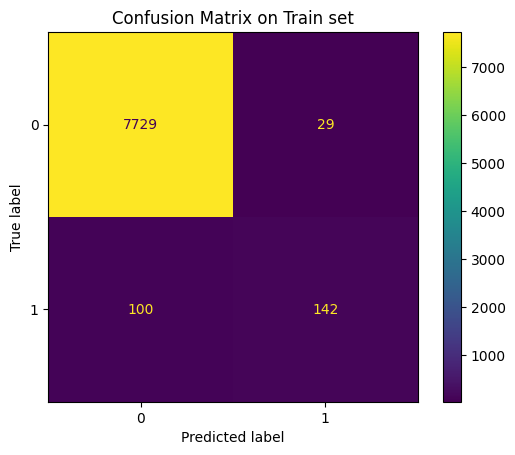

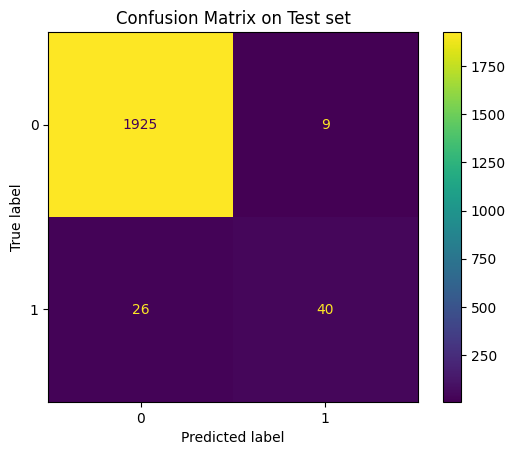

In [209]:
conf_matrix(classifier)

---

## Model training and evaluation

Using only one feature does not seem to be very efficient. Let's try using all the features with differents types of model.

### Preprocessing

In [210]:
#Features and target
X = data_sample.drop('converted', axis=1)
y = data_sample['converted']

In [211]:
#Splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [212]:
#Prerocessing
numeric_features=['new_user', 'age','total_pages_visited']
categorical_features=['country','source']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

### Train model

In [213]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

randomforrest = RandomForestClassifier()
randomforrest.fit(X_train,y_train)

xgboost = XGBClassifier()
xgboost.fit(X_train,y_train) 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Evaluation

In [214]:
print(f"Logistic Regression f1 score on train set : {f1_score(y_train, logreg.predict(X_train)):.4f}")
print(f"Logistic Regression f1 score on test set : {f1_score(y_test, logreg.predict(X_test)):.4f}")

print(f"Random Forrest Cross-Validation f1 score on train set : {f1_score(y_train, randomforrest.predict(X_train)):.4f}")
print(f"Random Forrest Cross-Validation f1 score on test set : {f1_score(y_test, randomforrest.predict(X_test)):.4f}")

print(f"XGBoost Cross-Validation f1 score on train set : {f1_score(y_train, xgboost.predict(X_train)):.4f}")
print(f"XGBoost Cross-Validation f1 score on test set : {f1_score(y_test, xgboost.predict(X_test)):.4f}")



Logistic Regression f1 score on train set : 0.8214
Logistic Regression f1 score on test set : 0.7037
Random Forrest Cross-Validation f1 score on train set : 0.9602
Random Forrest Cross-Validation f1 score on test set : 0.7350
XGBoost Cross-Validation f1 score on train set : 0.9367
XGBoost Cross-Validation f1 score on test set : 0.6491


## Upgrade models

### Splitting

In [269]:
#Features and target
X = data_sample.drop('converted', axis=1)
y = data_sample['converted']

#Splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

### Preprocessing

In [271]:
#Prerocessing
numeric_features=['new_user', 'age','total_pages_visited']
categorical_features=['country','source']

numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ('poly', PolynomialFeatures(degree=2))
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder",OneHotEncoder(drop="first")) 
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [272]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

### Hyperparameter tuning 

In [273]:
param_grid_logreg = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

param_grid_randomforrest = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

param_grid_xgboost = { 
    "max_depth": [2, 4, 6, 8, 10],
    "min_child_weight": [1,2,3,4],
    "n_estimators": [10,12,14,16],
}


#### Logistic Regression

In [274]:
print("Gridsearch for logistic regression...")
logreg_gridsearch = GridSearchCV(LogisticRegression(), param_grid_logreg, cv=5, scoring='f1',verbose=2)
logreg_gridsearch.fit(X_train, y_train)

print("...Done.")
print("Best hyperparameters : ", logreg_gridsearch.best_params_)
print("Best validation f1 score : ", logreg_gridsearch.best_score_)
print()
print("f1 score on training set : ", logreg_gridsearch.score(X_train, y_train))
print("f1 score on test set : ", logreg_gridsearch.score(X_test, y_test))

Gridsearch for logistic regression...
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..

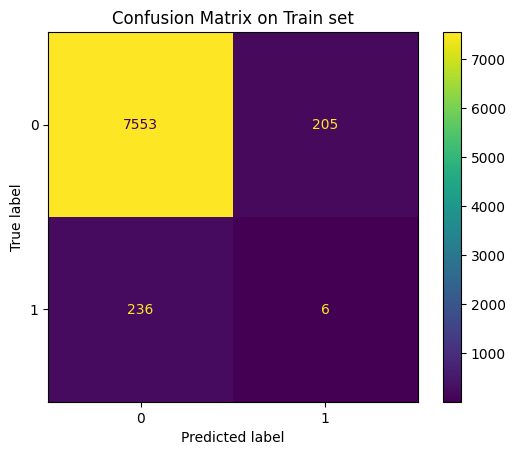

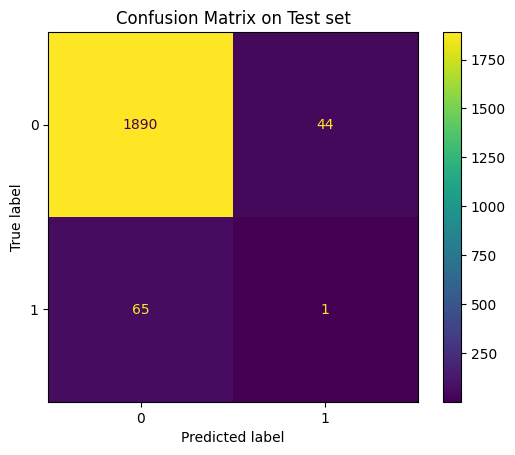

In [275]:
conf_matrix(logreg_gridsearch)

#### Random forrest

In [221]:

print("Gridsearch for random forrest...")
randomforrest_gridsearch = GridSearchCV(RandomForestClassifier(), param_grid_randomforrest, cv=5, scoring='f1', verbose=2)
randomforrest_gridsearch.fit(X_train, y_train)

print("...Done.")
print("Best hyperparameters : ", randomforrest_gridsearch.best_params_)
print("Best validation f1 score : ", randomforrest_gridsearch.best_score_)
print()
print("f1 score on training set : ", randomforrest_gridsearch.score(X_train, y_train))
print("f1 score on test set : ", randomforrest_gridsearch.score(X_test, y_test))

Gridsearch for random forrest...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] E

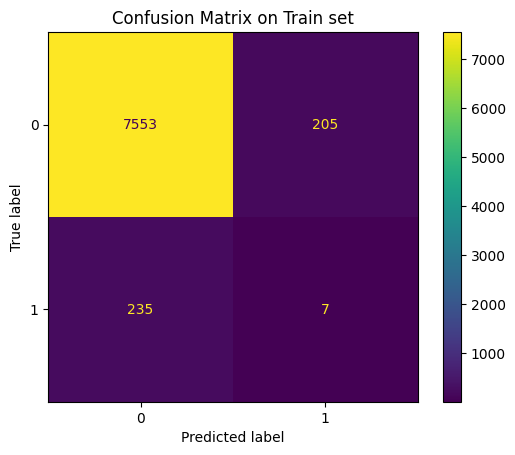

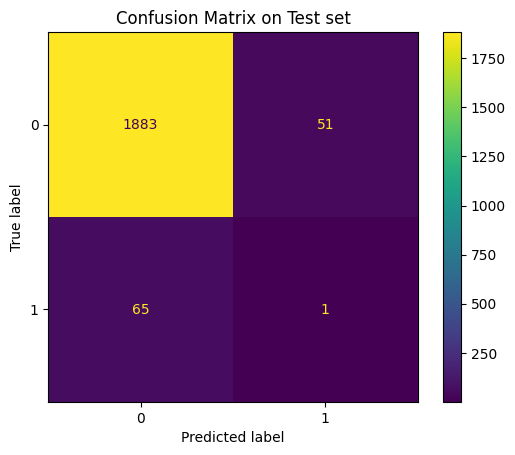

In [222]:
conf_matrix(randomforrest_gridsearch)

#### XGBoost

In [223]:
print("Gridsearch for XGBoost...")
xgboost_gridsearch = GridSearchCV(XGBClassifier(), param_grid_xgboost, cv=5, scoring='f1', n_jobs=1, verbose=2)
xgboost_gridsearch.fit(X_train, y_train)

print("...Done.")
print("Best hyperparameters : ", xgboost_gridsearch.best_params_)
print("Best validation f1 score : ", xgboost_gridsearch.best_score_)
print()
print("f1 score on training set : ", xgboost_gridsearch.score(X_train, y_train))
print("f1 score on test set : ", xgboost_gridsearch.score(X_test, y_test))

Gridsearch for XGBoost...
Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END ...max_depth=2, min_child_weight=1, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=2, min_child_weight=1, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=2, min_child_weight=1, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=2, min_child_weight=1, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=2, min_child_weight=1, n_estimators=10; total time=   0.0s
[CV] END ...max_depth=2, min_child_weight=1, n_estimators=12; total time=   0.0s
[CV] END ...max_depth=2, min_child_weight=1, n_estimators=12; total time=   0.0s
[CV] END ...max_depth=2, min_child_weight=1, n_estimators=12; total time=   0.0s
[CV] END ...max_depth=2, min_child_weight=1, n_estimators=12; total time=   0.0s
[CV] END ...max_depth=2, min_child_weight=1, n_estimators=12; total time=   0.0s
[CV] END ...max_depth=2, min_child_weight=1, n_estimators=14; total time=   0.0s
[CV] END ...max_depth

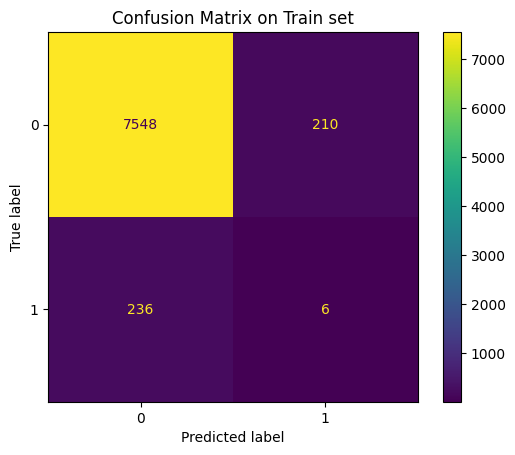

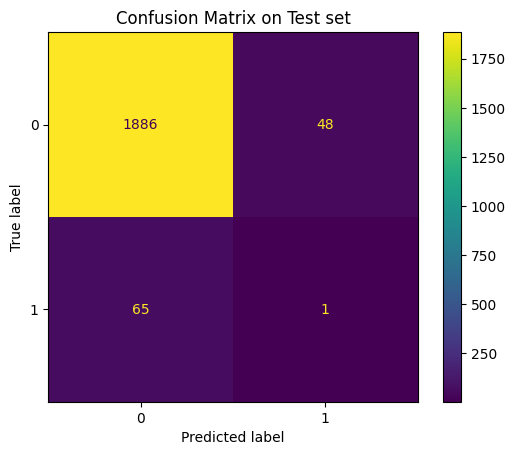

In [224]:
conf_matrix(xgboost_gridsearch)

#### Voting

In [225]:
voting = VotingClassifier(
    estimators=[
        ("logreg", logreg_gridsearch.best_estimator_),
        ("random_forest", randomforrest_gridsearch.best_estimator_),
        ("XGBoost", xgboost_gridsearch.best_estimator_)
    ],
    voting="hard",
)  # soft: use probabilities for voting

voting.fit(X_train, y_train)

VotingClassifier(estimators=[('logreg', LogisticRegression(C=10)),
                             ('random_forest',
                              RandomForestClassifier(max_depth=10,
                                                     max_features='log2',
                                                     min_samples_split=5,
                                                     n_estimators=200)),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=Non...
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None, min_child_weight=3,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=16, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))])

In [226]:
y_train_pred = voting.predict(X_train)
y_test_pred = voting.predict(X_test)

print("f1 score on the train set : ", f1_score(y_train, y_train_pred))
print("f1 score on the test set : ", f1_score(y_test, y_test_pred))

f1 score on the train set :  0.8533916849015317
f1 score on the test set :  0.7027027027027027


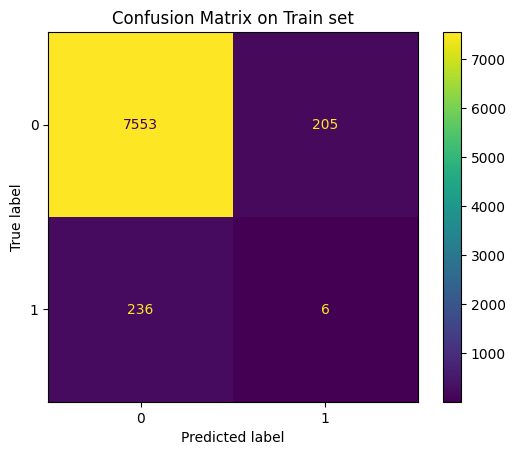

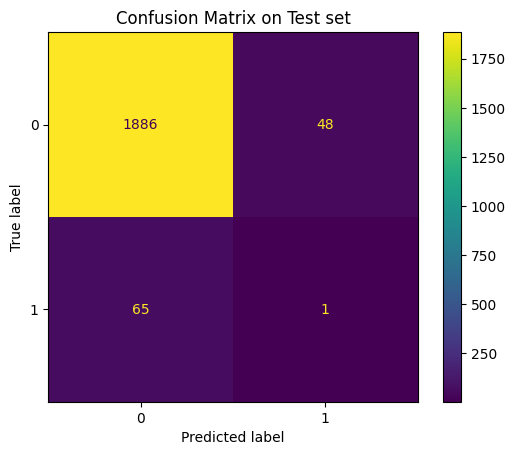

In [227]:
conf_matrix(voting)

### Feature Importance

In [276]:
best_model = logreg_gridsearch.best_estimator_

In [277]:
best_model.coef_

array([[-3.95638112, -2.16935549, -0.49897513,  1.89157029, -2.21623609,
         0.10973842, -0.21235442,  0.08960907, -0.09205597,  0.23508732,
         4.67895626,  4.17789984,  3.67603635, -0.34704395, -0.03389981]])

In [279]:
column_names = []
for name, transformer, features_list in preprocessor.transformers_:
    if name == 'num':  # Numeric features
        poly_feature_names = transformer.named_steps['poly'].get_feature_names_out(features_list)
        column_names.extend(poly_feature_names)
    else:  # Categorical features
        onehot_feature_names = transformer.named_steps['encoder'].get_feature_names_out(features_list)
        column_names.extend(onehot_feature_names)
        
print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  ['1', 'new_user', 'age', 'total_pages_visited', 'new_user^2', 'new_user age', 'new_user total_pages_visited', 'age^2', 'age total_pages_visited', 'total_pages_visited^2', 'country_Germany', 'country_UK', 'country_US', 'source_Direct', 'source_Seo']


------

In [283]:
coefs = pd.DataFrame(index = column_names, data = best_model.coef_.transpose(), columns=["coefficients"])
# Compute abs() and sort values
feature_importance = abs(coefs).sort_values(by = 'coefficients')
feature_importance

,coefficients
source_Seo,0.033900
age^2,0.089609
age total_pages_visited,0.092056
new_user age,0.109738
new_user total_pages_visited,0.212354
total_pages_visited^2,0.235087
source_Direct,0.347044
age,0.498975
total_pages_visited,1.891570
new_user,2.169355


In [284]:
# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()


If we look at the importance of features, we can see that the user's country has a major influence on the result.  
**'Data Science Weekly'** can improve convesion rate by paying more attention to the user's country. The company could adapt the content to suit the user's country.

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [287]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(y_train,y_test)

best_model.fit(X,Y)

LogisticRegression(C=10)

In [290]:
# Read data without labels
data_without_labels = pd.read_csv('src/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['age', 'new_user', 'total_pages_visited','country', 'source']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
#X_without_labels = X_without_labels.values
print("...Done")

#print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done


In [291]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 1.00000000e+00 -1.47850657e+00 -2.99910530e-01  3.37759328e+00
   2.18598168e+00  4.43419689e-01 -4.99379385e+00  8.99463260e-02
  -1.01297579e+00  1.14081363e+01  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  6.76358171e-01 -1.03188315e+00  4.27466701e-02
   4.57460375e-01 -6.97922597e-01  2.89120596e-02  1.06478283e+00
  -4.41095685e-02  1.82727781e-03  0.00000000e+00  1.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  6.76358171e-01  1.88071214e-01 -1.16992482e+00
   4.57460375e-01  1.27203502e-01 -7.91288214e-01  3.53707816e-02
  -2.20029182e-01  1.36872409e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  6.76358171e-01  1.88071214e-01  3.45914543e-01
   4.57460375e-01  1.27203502e-01  2.33962128e-01  3.53707816e-02
   6.50565682e-02  1.19656871e-01  0.000000

In [322]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': best_model.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions.csv', index=False)


### Checking on test set

In [320]:
test_set = pd.read_csv("src/conversion_data_test_labels.csv")

In [321]:
print("f1_score on test set : " , f1_score(test_set, Y_predictions))

f1_score on test set :  0.7561761546723953
